In [18]:
import numpy as np
import scipy

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [73]:
class ImplicitMixer(nn.Module):
    def __init__(self, noise_dim, n_coeffs):
        super().__init__()
        self.noise_dim = noise_dim
        self.n_coeffs = n_coeffs
        
        self.encoder = nn.Sequential(nn.Linear(noise_dim, 100),
                                     nn.ReLU(),
                                     nn.Linear(100, 200),
                                     nn.ReLU(),
                                     nn.Linear(200, 100),
                                     nn.ReLU()
                                    )
        self.range_mean = nn.Linear(100, 1)
        self.nugget_mean = nn.Linear(100, 1)
        self.coeff_means = nn.Linear(100, n_coeffs)
    
    def forward(self, noise):
        enc = self.encoder(noise)
        return self.range_mean(enc), self.nugget_mean(enc), self.coeff_means(enc)

class QLogNormal(nn.Module):
    '''
    log normal conditional approximation for phi
    '''
    def __init__(self, logsigma0=0.):
        super().__init__()
        self.logsigma = nn.Parameter(torch.tensor(logsigma0))
    
    def pdf(self, x, mu):
        ln = torch.distributions.LogNormal(mu, self.logsigma.exp())
        return torch.exp(ln.log_prob(x))
    
    def forward(self, mu):
        ln = torch.distributions.LogNormal(mu, self.logsigma.exp())
        return ln.rsample()

class QMVN(nn.Module):
    '''
    normal conditional approximation for beta
    '''
    def __init__(self, n_coeffs, cov_init = None):
        super().__init__()
        self.n_coeffs = n_coeffs
        if cov_init is not None:
            cov = cov_init
        else:
            cov = torch.diag(torch.ones(n_coeffs))
        self.cov = nn.Parameter(cov)
    
    def pdf(self, x, mu):
        mvn = torch.distributions.MultivariateNormal(mu, self.cov)
        return torch.exp(mvn.log_prob(x))
    
    def forward(self, mu):
        mvn = torch.distributions.MultivariateNormal(mu, self.cov)
        return mvn.rsample()
    
class QNormal(nn.Module):
    '''
    diagonal normal conditional approximation for beta
    '''
    def __init__(self, n_coeffs, logsigma0=0.):
        super().__init__()
        self.logsigma = nn.Parameter(torch.tensor(logsigma0))
    
    def pdf(self, x, mu):
        normal = torch.distributions.Normal(mu, self.logsigma.exp())
        return torch.exp(normal.log_prob(x).sum(1))
    
    def forward(self, mu):
        normal = torch.distributions.Normal(mu, self.logsigma.exp())
        return normal.rsample()
    
def train(y, X, s, range_prior, nugget_prior, coeff_prior, 
          q_range, q_nugget, q_coeff, mixer, optimizer, 
          K=20, J=10, iter=100, interval=100):
    dist_mat = torch.Tensor(scipy.spatial.distance_matrix(s, s))
    n = s.shape[0]
    losses = []
    for epoch in range(iter):
        if epoch % interval == 0: print("Iteration " + str(epoch))
        eps = torch.randn((K, mixer.noise_dim))
        range_means, nugget_means, coeff_means = mixer(eps)
        optimizer.zero_grad()
        loss = 0
        for j in range(J):
            eps_j = torch.randn((1, mixer.noise_dim))
            range_mean_j, nugget_mean_j, coeff_means_j = mixer(eps_j)
            range_sample = q_range(range_mean_j)
            nugget_sample = q_nugget(nugget_mean_j)
            coeff_sample = q_coeff(coeff_means_j)
            
            q_sum = q_range.pdf(range_sample, mu = range_means).sum() + \
                    q_nugget.pdf(nugget_sample, mu = nugget_means).sum() + \
                    q_coeff.pdf(coeff_sample, mu = coeff_means).sum()
            q_inner = q_range.pdf(range_sample, mu = range_mean_j) + \
                      q_nugget.pdf(nugget_sample, mu = nugget_mean_j) + \
                      q_coeff.pdf(coeff_sample, mu = coeff_means_j)
            log_H = -torch.log((q_sum + q_inner) / (K+1))
            
            cov_mat = exp_cov(dist_mat, phi = range_sample)
            model_cov = cov_mat + nugget_sample * torch.diag(torch.ones(n))
            model = torch.distributions.MultivariateNormal(loc = X.mm(coeff_sample.t()).t(),
                                                           covariance_matrix = model_cov)
            log_p = model.log_prob(y.t()) + \
                    range_prior.log_prob(range_sample) + \
                    nugget_prior.log_prob(nugget_sample) + \
                    coeff_prior.log_prob(coeff_sample)
            loss -= (log_H + log_p) / J
            
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
    return mixer, q_range, q_nugget, q_coeff, losses

In [74]:
def exp_cov(dists, phi, sigma=1):
    return sigma * torch.exp(- dists / phi)

def power_exp_cov(dists, phi, alpha):
    return torch.exp(- torch.pow(dists / phi, alpha))

## The data

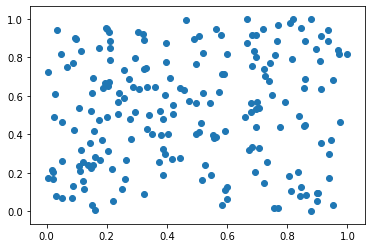

In [113]:
torch.manual_seed(0)
n = 200
s = torch.rand((n, 2))
plt.scatter(s[:,0].detach().numpy(), s[:, 1].detach().numpy(), marker = 'o')

In [114]:
phi_true = 5
tau2_true = 1
coeff_true = torch.Tensor([1, -5, 10]).view(3, 1)
X = torch.cat((torch.ones(n, 1), s), 1)

cov_mat = exp_cov(torch.Tensor(scipy.spatial.distance_matrix(s, s)), phi = phi_true)
nugget = torch.distributions.MultivariateNormal(
    loc = torch.zeros(n), covariance_matrix = tau2_true * torch.diag(torch.ones(n))
)
spatial = torch.distributions.MultivariateNormal(
    loc = torch.zeros(n), covariance_matrix = cov_mat
)
w = spatial.sample().view(n, 1)
eps = nugget.sample().view(n, 1)

y = X.mm(coeff_true) + w + eps

In [115]:
q_range = QLogNormal()
range_prior = torch.distributions.Uniform(.01, 10)
q_nugget = QLogNormal()
nugget_prior = torch.distributions.TransformedDistribution(
    torch.distributions.Gamma(2, 1),                                                           
    torch.distributions.transforms.PowerTransform(-1)
)
# q_coeff = QMVN(coeff_true.shape[0])
q_coeff = QNormal(coeff_true.shape[0])
coeff_prior = torch.distributions.MultivariateNormal(
    loc = torch.zeros(coeff_true.shape[0]), 
    covariance_matrix = 10 * torch.diag(torch.ones(3))
)

mixer_noise_dim = 50
mixer = ImplicitMixer(mixer_noise_dim, coeff_true.shape[0])

optimizer = torch.optim.Adam(list(mixer.parameters()) 
                             + list(q_range.parameters())
                             + list(q_nugget.parameters()) 
                             + list(q_coeff.parameters())
                             ,
                             lr = 0.01, betas = (.9, .999))

In [116]:
mixer, q_range, q_nugget, q_coeff, losses = \
    train(y, X, s, range_prior, nugget_prior, coeff_prior,
          q_range, q_nugget, q_coeff, mixer, optimizer,
          K = 50, J = 20, iter = 200, interval = 10)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190


In [117]:
n_plot_samples = 5000
eps = torch.randn((n_plot_samples, mixer.noise_dim))
range_mean, nugget_mean, coeff_mean = mixer(eps)
phi = q_range(range_mean)
tau2 = q_nugget(nugget_mean)
beta = q_coeff(coeff_mean)

In [118]:
phi.median()
tau2.median()
phi.std()
tau2.std()

tensor(0.3907, grad_fn=<StdBackward0>)

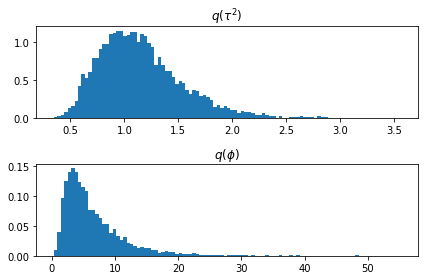

In [119]:
plt.subplot(2, 1, 1)
ax = plt.hist(tau2.detach().numpy(), density=True, label = '$q(\\tau^2)$',
            bins = 100)
plt.title('$q(\\tau^2)$')
plt.subplot(2, 1, 2)
plt.hist(phi.detach().numpy(), density=True, label = '$q(\phi)$',
            bins = 100)
plt.title('$q(\phi)$')

plt.tight_layout()

plt.savefig("sivi_var_posterior.pdf")

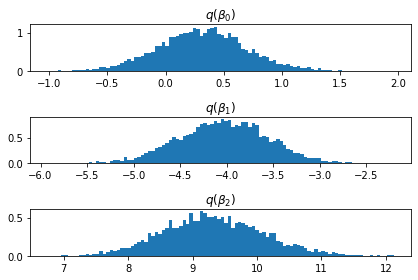

In [120]:
for i in range(beta.shape[1]):
    plt.subplot(3, 1, i+1)
    plt.hist(beta[:, i].detach().numpy(), density=True, label = '$q(\beta)$',
             bins = 100)
    plt.title("$q(\\beta_{})$".format(i))

plt.tight_layout()

plt.savefig("sivi_beta_posterior.pdf")

In [123]:
print(beta.mean(0))
print(beta.std(0))

tensor([ 0.3140, -4.0352,  9.3224], grad_fn=<MeanBackward1>)
tensor([0.3788, 0.4876, 0.7795], grad_fn=<StdBackward1>)


Text(0.5, 0, 'Iteration')

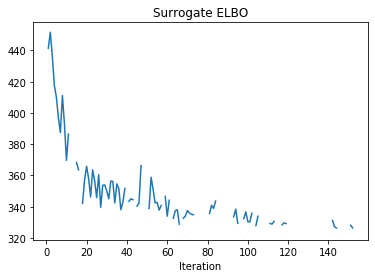

In [124]:
plt.figure()
plt.plot(torch.cat(losses).detach().numpy())
plt.title("Surrogate ELBO")
plt.xlabel("Iteration")

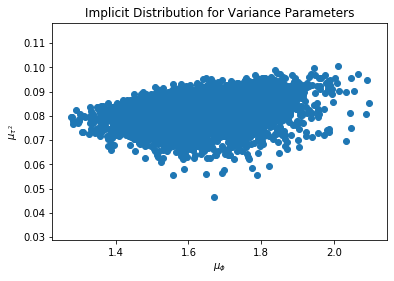

In [125]:
plt.figure()
plt.scatter(range_mean.detach().numpy(), nugget_mean.detach().numpy())
plt.xlabel("$\mu_\phi$")
plt.ylabel("$\mu_{\\tau^2}$")
plt.title("Implicit Distribution for Variance Parameters")
plt.savefig("sivi_var_corr.pdf")

In [126]:
losses

[tensor([[inf]], grad_fn=<SubBackward0>),
 tensor([[441.4362]], grad_fn=<SubBackward0>),
 tensor([[451.6764]], grad_fn=<SubBackward0>),
 tensor([[436.4075]], grad_fn=<SubBackward0>),
 tensor([[417.6685]], grad_fn=<SubBackward0>),
 tensor([[410.2483]], grad_fn=<SubBackward0>),
 tensor([[397.0690]], grad_fn=<SubBackward0>),
 tensor([[387.4862]], grad_fn=<SubBackward0>),
 tensor([[411.1601]], grad_fn=<SubBackward0>),
 tensor([[393.2043]], grad_fn=<SubBackward0>),
 tensor([[369.6521]], grad_fn=<SubBackward0>),
 tensor([[386.4171]], grad_fn=<SubBackward0>),
 tensor([[inf]], grad_fn=<SubBackward0>),
 tensor([[366.3589]], grad_fn=<SubBackward0>),
 tensor([[inf]], grad_fn=<SubBackward0>),
 tensor([[368.2798]], grad_fn=<SubBackward0>),
 tensor([[363.6018]], grad_fn=<SubBackward0>),
 tensor([[inf]], grad_fn=<SubBackward0>),
 tensor([[342.1866]], grad_fn=<SubBackward0>),
 tensor([[357.4256]], grad_fn=<SubBackward0>),
 tensor([[365.8773]], grad_fn=<SubBackward0>),
 tensor([[358.1797]], grad_fn=<Su